# Mask R-CNN - Inspect SunRGBD Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [24]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.sunrgbd import sun, dataset, sun_config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

print(os.getcwd())
depth_mode = True

c:\Users\Yannick\Google Drive\instance_segmentation\Mask_RCNN\samples\sunrgbd


## Configurations

In [25]:
config = sun_config.SunConfig(depth_mode=depth_mode)
config.display()
SUN_DIR = 'C:/Users/Yannick/Downloads/SUNRGBD/'
sun.ROOT_DIR = ROOT_DIR
sun_config.ROOT_DIR = ROOT_DIR
dataset.ROOT_DIR = ROOT_DIR
print(sun_config.ROOT_DIR)

Depth mode enabled

Configurations:
AUGMENTATION_NUM               2
AUGMENTATION_STRENGTH          3
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.

In [26]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

config = InferenceConfig(depth_mode=depth_mode)
config.BATCH_SIZE = 1
config.DETECTION_MIN_CONFIDENCE = 0.3

config.display()

Depth mode enabled

Configurations:
AUGMENTATION_NUM               2
AUGMENTATION_STRENGTH          3
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      0
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.

## Notebook Preferences

In [17]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [27]:
def get_ax(rows=1, cols=1, size=14):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Test Dataset

In [28]:
# Load validation dataset

IGNORE_IMAGES_PATH = os.path.abspath('../../skip_image_paths.txt')

if depth_mode: 
    sun_dataset = dataset.SunDataset3D(skip_images_path=IGNORE_IMAGES_PATH)
else: 
    sun_dataset = dataset.SunDataset2D(skip_images_path=IGNORE_IMAGES_PATH)
sun_dataset.load_sun(SUN_DIR, subset="test")

# Must call before using the dataset
sun_dataset.prepare()

print("Images: {}\nClasses: {}".format(len(sun_dataset.image_ids), sun_dataset.class_names))

Images: 1845
Classes: ['BG', 'bed', 'chair', 'table', 'sofa', 'bookcase']


## Load Model

In [29]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

## Run Detection

In [30]:
# Load weights
SUN_WEIGHTS_PATH = os.path.join(ROOT_DIR, 'logs/local_best_models/depth_best.h5')  # TODO: update this path
print("Loading weights ", SUN_WEIGHTS_PATH)

model.load_weights(SUN_WEIGHTS_PATH, by_name=True)


Loading weights  c:\Users\Yannick\Google Drive\instance_segmentation\Mask_RCNN\logs/local_best_models/depth_best.h5
Re-starting from epoch 0  in directory  local_best_models


image ID: sun.4350 (874) C:/Users/Yannick/Downloads/SUNRGBD/kv2/kinect2data/002532_2014-06-24_13-35-33_094959634447_rgbf000075-resize/image/0000075.jpg
874
Processing 1 images
image                    shape: (512, 512, 4)         min:    0.00000  max: 40266.00000  uint16
molded_images            shape: (1, 512, 512, 4)      min: -128.00000  max: 40138.00000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
[0.46514824 0.4449402  0.42216805 0.39587823 0.3298034 ]
gt_class_id              shape: (4,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max:  438.00000  int32
gt_mask                  shape: (512, 512, 4)         min:    0.00000  max:    1.00000  bool


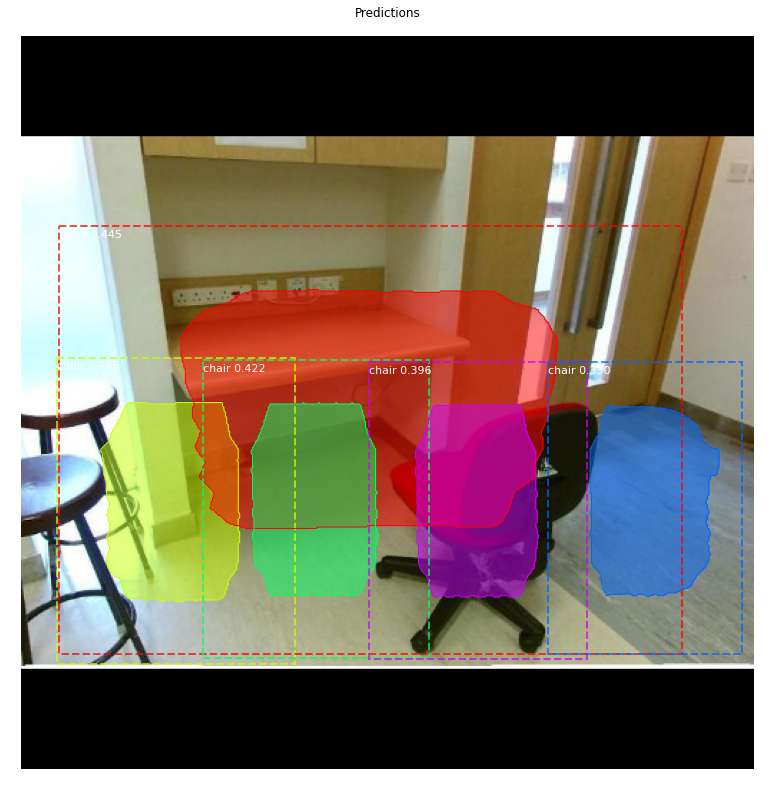

In [31]:
image_id = random.choice(sun_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(sun_dataset, config, image_id, use_mini_mask=False)
info = sun_dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       sun_dataset.image_reference(image_id)))
print(image_id)
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
print(r['scores'])
if depth_mode:
    image = image[:,:,:3]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            sun_dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)